<a href="https://colab.research.google.com/github/nishap1225/Text-Message-Analyzer/blob/master/Text_Message_Analyzer-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Message Analyzer

This summer, we used our text messages as our dataset and Google's pretrained NLP model BERT to help us analyze our data in several different ways. We started off by using BERT embeddings and scikit-learn in order to classify our text messages by author. Then, we used T-SNE to visualize the embeddings and see how our conversations were affected by COVID-19.

##Part 1: Text Message Classification

This colab notebook trains a DistilBERT model with our texts; the model is then used to predict which of us wrote a given text.  

### 1. Importing packages and libraries



We used transformers in order to use the DistilBert model, as well as several libraries including Pytorch, numpy, scikit and pandas.




In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
from datetime import datetime as datetime
import io

###2. Uploading and processing data files 

**Here**, we upload Reena's text messages .csv file (which was obtained from iMessage), and reading it into a pandas dataframe. Additionally, we add a column called *sender* which has all values set to 0 to signify that these are Reena's texts. 

NOTE: We chose to upload the data sets from our local computers because the contents (our text messages) are private. 

In [ ]:
uploaded_reena = files.upload()

In [ ]:
df_reena = pd.read_csv(io.StringIO(uploaded_reena['onlyreena.csv'].decode('utf-8', 'ignore')), error_bad_lines=False, names=['text', 'date'])
df_reena['sender'] = [0]*len(df_reena.index)
df_reena.head() #This prints the first few lines of the dataframe to confirm the formatting is correct. 

Since images were saved as a string of length 1, we had to go through each text and drop texts that did not have the content we wanted.

In [ ]:
dropped = []
for index, row in df_reena.iterrows():
  if len(row['text']) == 1:
    dropped.append(index)

df_reena = df_reena.drop(dropped)

In [ ]:
df_reena['date'] = df_reena['date'].apply(lambda x: pd.to_datetime(x))

Next, we upload a .json file containing all of Nisha's text messages. The file was downloaded from Facebook Messenger. Because of the abnormal format of the file, more cleaning had to be done. 

In [ ]:
uploaded_nisha = files.upload()

Saving merged_file.json to merged_file (1).json


Clean is a helper method that deletes all uneccessary information from the .json file such as the reactions on a given message and what photos were sent. 

In [ ]:
def clean(dic): 
  dic.pop("type", None)
  dic.pop("reactions", None)
  dic.pop("share", None)
  dic.pop("ip", None)
  dic.pop("sticker", None)
  dic.pop("photos", None)
  dic.pop("users", None)
  dic.pop("call_duration", None)
  dic.pop("videos", None)
  dic.pop("gifs", None)
  dic.pop("files", None)
  dic.pop('missed', None)
  dic.pop("audio_files", None)

We read the contents of the .json file into a list called data. This method processes the dictionaries from data[1] ... the last element. In it, we delete all the extraneous data that the .json file gave us using the *clean* method. Also, we filtered to only include texts that Nisha sent. 

In [ ]:
def addtoDf(dic, all): # all is True if we want all of the texts, and all is false if we want my texts 
  del dic['participants']
  del dic['title']
  del dic['is_still_participant']
  del dic['thread_type']
  del dic['thread_path']

  end = []

  for element in dic['messages']: 
    clean(element)
    if all: 
      if(element["sender_name"] == "Nisha Prabhakar"): 
        element.pop("sender_name")
        end.append(element)
    else:
      element.pop("sender_name")
      end.append(element) 
  
  with open("memory.json", "w") as write_file:
    json.dump(end, write_file)

  return pd.read_json('memory.json')

This method is called on the dictionaries in data[0]. Because the dictionary format is slightly different, we had to build a separate method to process it. It does roughly the same thing as *addtoDf*.

In [ ]:
def addtoDfFirst(dic, all):
  clean(dic)
  
  if (all and dic['sender_name'] != "Nisha Prabhakar"):
    return pd.DataFrame() 

  with open("memory.json", "w") as write_file:
    json.dump(dic, write_file)

  return pd.read_json('memory.json', typ='series')

This is the overarching procedure to clean the file uploaded_nisha and create one pandas dataframe that contains the data. When the data was loaded, we received a list (called data). The first element of data was a list itself, whose elements were dictionaries. On the other hand, the second element of data through the last element were dictionaries.   

In [ ]:
import json
with open('merged_file.json') as json_data:
  data = json.load(json_data)
  df_nisha = pd.DataFrame() 
  for dictionary in data[0]:     
    df_new = addtoDfFirst(dictionary, False)
    df = df_nisha.append(df_new, ignore_index=True)
    df_nisha = df
  for i in range(1, len(data)): 
    df_new = addtoDf(data[i], False)
    df = df_nisha.append(df_new, ignore_index=True)
    df_nisha = df

In order to match the formats of **df_reena** and **df_nisha**, we deleted the "sender_name" column and created a new column of all 1's, which identified the texts as being written by Nisha. Additionally, we changed the other two column names to match **df_reena**.

In [ ]:
del df_nisha['sender_name']
df_nisha['sender'] = [1]*len(df_nisha.index)
df_nisha.columns=['text', 'date', 'sender']
df_nisha.head()

Since there were some irregularities in Nisha's message file (some of the text messages were not of the String datatype), we iterated through each text and deleted the offending texts. 

In [ ]:
df_nisha = df_nisha[11:]
dropped = []
for index, row in df_nisha.iterrows():
  if not isinstance(row['text'], str):
    dropped.append(index)

df_nisha = df_nisha.drop(dropped)
df_nisha=df_nisha.sort_values(by=['date'])
df_nisha.head() #This prints the first few lines of the dataframe to confirm the formatting is correct. 

In [ ]:
type(df_nisha['date'][32046])

pandas._libs.tslibs.timestamps.Timestamp

For performance purposes we only used the most recent 2000 texts. We also concatenated **df_nisha** and **df_reena** and sorted the resulting df_total by date. 

In [ ]:
df_nisha_short = df_nisha[-2000:]
df_reena_short = df_reena[-2000:]
df = df_reena_short.append(df_nisha_short, ignore_index=True)
df_total = df_reena.append(df_nisha, ignore_index=True)
#del df['date']

In [ ]:
df_total.head()

In [ ]:
df_total=df_total.sort_values(by=['date'])

In [ ]:
df_total.head()

###3. Extracting DistilBert Embeddings

 We followed this [tutorial](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) by Jay Alammar for the DistilBERT analysis. 

We began by loading in the DistilBERT model and other relevant classes. 

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

This method completely encodes all of the texts. After adding the special "[CLS]" and "[SEP]" tokens at the beginning and end of the texts, we tokenized the texts. The tokenizer splits up words that are not in its default dictionary into smaller parts and assigns them their associated ID. Although initially we chose to maximize the length of our tokenized text array (512), this caused extracting the embeddings to use far too much RAM. We realized that only 6 of texts had more than 50 tokens, so we decided to set 50 as the maximum length of a tokenized text message. 

In [ ]:
def modified_encoder(x):
  marked_text = "[CLS] " + x + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text[:50])
  return indexed_tokens

We applied the *modified_encoder* function to every string in the **text** column of **df**. 

In [ ]:
tokenized = df['text'].apply(modified_encoder)

In [ ]:
type(tokenized.to_numpy())

numpy.ndarray

Here, we convert our list of tokenized texts (each text is represented as a list) into a two dimensional numpy array. This allows us to calculate the embeddings of all the texts at once. 

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape #A size of 4000 x 50 for our array padded makes sense because we set our maximum tokenized text length to be 50. 

(4000, 50)

Our array **padded** is a uniform array where each text is represented by an array of integers of size 50. However, we need to tell BERT to ignore the extra 0's padded onto texts whose length is less than 50, so we created an array of integers called the **attention_mask**.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape #The attention mask has the same shape as the padded array. 

(4000, 50)

We retrieve the embeddings from the model by converting **padded** and **attention_mask** into tensors and passing them into our model.

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

###4. Creating and training scikit model

We currently have embeddings for each word in each text. We use the first element of **last_hidden_states**, which is the last layer of the neural network. <br>
In order to consolidate this data into one embedding for each text, we use the embedding for the "[CLS]" token, which is the first token and often used to represent the sentence as a whole.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

Here we split our data into training and testing data.


In [ ]:
labels = df['sender']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

We fit the model to our data.

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We used *test_features* and *test_labels* to see how well our model scored against the testing data. It does fairly well, with an accuracy of about 81.4%. 

In [ ]:
lr_clf.score(test_features, test_labels)

0.807

###5. Testing our model with inputs

*prepare* converts a text string to its embeddings. This is necessary to prepare the texts to feed into our model, which is based on vectors, not strings.



In [ ]:
def prepare(x):
  tokenized = tokenizer.encode(x, add_special_tokens=True)
  input_ids = torch.tensor([tokenized])  
  with torch.no_grad():
    last_hidden_states = model(input_ids)
  return last_hidden_states[0][0][0].unsqueeze(0).numpy()

*guess* calls on our model to predict who wrote the given text, and then interprets the integer returned back to a string with the person's name.

In [ ]:
def guess():
  x = input("Enter a text!")
  sender = lr_clf.predict(prepare(x))[0]
  if sender == 1:
    return 'nisha'
  else:
    return 'reena'

In [ ]:
guess()

##Part 2: Visualizing Bert Embeddings

Here, we used T-SNE in order to reduce the length of our embeddings from length 768 to 2. This way we were able to visualize our sentence embeddings by plotting them on a 2-D graph.

###1. Importing packages and libraries

We used the ski-kit machine learning library for TSNE and matplotlib to graph our points.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

###2. Splitting up our dataset

Due to the COVID-19 pandemic, our daily lives were significantly impacted, especially when our second semester went remote. Assuming our text messages would reflect this change, we wanted to see how our texts would look before shelter-in-place, during shelter-in-place, and after summer break started. As a result, we split up our dataset accordingly into three parts. We also had to change the step size for each dataframe in order to keep our number of texts to be around 4000.

In [ ]:
spring_semester = datetime(2020, 1, 20)
covid = datetime(2020, 3, 20)
summer_break = datetime(2020, 5, 15)
df_precovid = df_total[(df_total['date'] > spring_semester) & (df_total['date'] < covid)].iloc[::2, :]
df_postcovid = df_total[(df_total['date'] > covid) & (df_total['date'] < summer_break)].iloc[::3, :]
df_summer = df_total[df_total['date'] > summer_break].iloc[::, :]

###3. Embedding and graphing

The *embed* function gets embeddings the same way we did for text classification above. The *graph* function then uses the embeddings and authors returned by the *embed* function to plot the texts. The color of each point on the graph is determined by the author.

In [ ]:
import pdb

def embed(df):
  tokenized = df['text'].apply(modified_encoder)
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)
  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

  features = last_hidden_states[0][:,0,:].numpy()
  labels = df['sender']

  return features, labels


In [ ]:
def graph(points, senders, title):
  two_points = TSNE(n_components=2).fit_transform(points)
  figure(figsize=(6,6))
  for i, sender in enumerate(senders):
    if sender == 1:
      plt.scatter(two_points[i][0], two_points[i][1], marker='.', c='b')
    else:
      plt.scatter(two_points[i][0], two_points[i][1], marker='.', c='r')
  plt.axis([-120, 120, -120, 120])
  plt.title(title)
  plt.savefig('postcovid.png')
  files.download('postcovid.png')
  plt.show()

In [ ]:
features_precovid, labels_precovid = embed(df_precovid)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

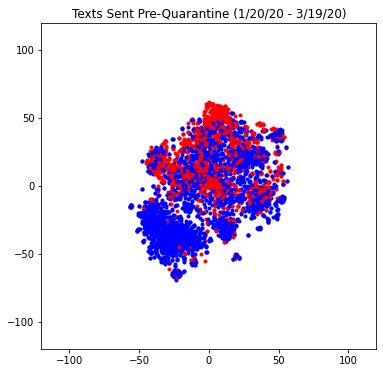

In [ ]:
graph(features_precovid, labels_precovid, 'Texts Sent Pre-Quarantine (1/20/20 - 3/19/20)')

In [ ]:
features_postcovid, labels_postcovid = embed(df_postcovid)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

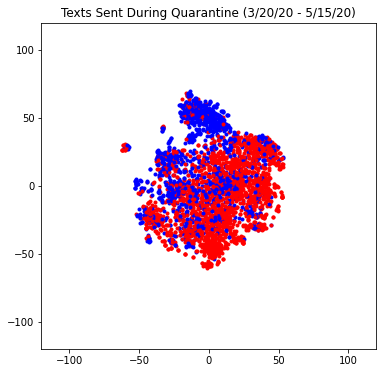

In [ ]:
graph(features_postcovid, labels_postcovid, 'Texts Sent During Quarantine (3/20/20 - 5/15/20)')

In [ ]:
features_summer, labels_summer = embed(df_summer)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

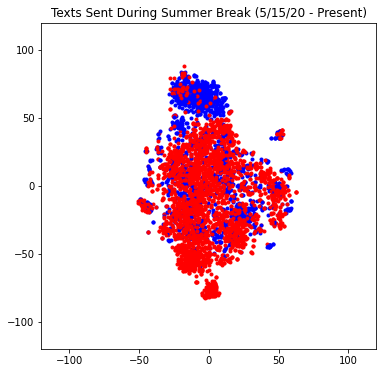

In [ ]:
graph(features_summer, labels_summer, 'Texts Sent During Summer Break (5/15/20 - Present)')

We found our results to be really interesting, especially because of the differences between the three plots. The points on the first and second graph have a much lower spread compared to the third graph. We reasoned that this is because the subject of our text messages, similar to our daily activities, became less restrained after school ended. The spread of the first and second graph are fairly similar, however the second graph is slightly more compact and the red and blue texts are less differentiable. We think this likely reflects the way Covid-19 made our daily lives even more similar than they were at Berkeley (same major, classes, dorms), the most significant similarity being quarantine.

##Part 3: Finding Word Similarity

In order to match words with similar meanings to each other, we created a cosine similarity matrix. This symmetric matrix included the cosine similarity calculation of every word to every other word. 

We imported the cosine_similarity package from the sklearn.metrics.pairwise library in order to calculate the cosine similarity. 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

We adjusted our data cleaning to include text messages sent to us as well as our own. 

In [ ]:
import json
with open('merged_file.json') as json_data:
  data = json.load(json_data)
  df_nisha_all = pd.DataFrame() 
  for dictionary in data[0]:     
    df_new = addtoDfFirst(dictionary, True)
    df = df_nisha_all.append(df_new, ignore_index=True)
    df_nisha_all = df
  for i in range(1, len(data)): 
    df_new = addtoDf(data[i], True)
    df = df_nisha_all.append(df_new, ignore_index=True)
    df_nisha_all = df

In [ ]:
del df_nisha_all['sender_name']
del df_nisha_all['timestamp_ms']
df_nisha_all.columns=['text']
df_nisha_all.head()

In [ ]:
dropped = []
for index, row in df_nisha_all.iterrows():
  if not isinstance(row['text'], str):
    dropped.append(index)

df_nisha_all = df_nisha_all.drop(dropped)

In [ ]:
uploaded_reena_all = files.upload()

In [ ]:
df_reena_all = pd.read_csv(io.StringIO(uploaded_reena_all['allreena.csv'].decode('utf-8', 'ignore')), error_bad_lines=False, names=['text', 'date'])

In [ ]:
dropped = []
for index, row in df_reena_all.iterrows():
  if not isinstance(row['text'], str):
    dropped.append(index)
  elif len(row['text']) == 1:
    dropped.append(index)

df_reena_all = df_reena_all.drop(dropped)

In [ ]:
del df_reena_all['date']

In [ ]:
df_master = df_reena_all.append(df_nisha_all)

In [ ]:
df_master.head()

We added slang to the tokenizer's default vocab so that our analysis would be more accurate. Below, we can see that the tokenizer has 30,537 words in its vocabulary. 

In [ ]:
len(tokenizer.get_vocab()) 

30522

In [ ]:
tokenizer.add_tokens(['bruh', 'glowed up', 'highkey', 'flex', 'finesse', 'bougie', 'cringey','thicc', 
                      'fam', 'lit', 'lowkey', 'oof', 'slaps', 'stan', 'squad', 'sus', 'vibin', 'vibes', 'yeet', 'bro', 'dude'])

15

In [ ]:
model.resize_token_embeddings(len(tokenizer)) 

Embedding(30537, 768)

In [ ]:
len(tokenizer.get_vocab())

30537

We slightly modified our previous embedding methodology to have it return the embeddings for every word, instead of just the sentence token. 

In [ ]:
def embed_words(df):
  tokenized = df['text'].apply(modified_encoder)
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  attention_mask = np.where(padded != 0, 1, 0)
  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)
  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

  return last_hidden_states[0]

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We cut down our dataframe so that we could run it in a reasonable amount of time. 

In [ ]:
df_master_short = df_master[::3]

We embedded our texts in batches so that there would be enough RAM in our environment to run without crashing. 

In [ ]:
start = 0
end = len(df_master_short.index)//10
jump = end 
embeddings = []
for i in range(5): 
  print(i)
  df_master_temp = df_master_short.iloc[start:end]
  embeddings_temp = embed_words(df_master_temp)
  start = end
  end = end + jump
  embeddings.extend(embeddings_temp)

In [ ]:
for i in range(5): 
  print(i)
  df_master_temp = df_master_short.iloc[start:end]
  embeddings_temp = embed_words(df_master_temp)
  start = end
  end = end + jump
  embeddings.extend(embeddings_temp)

*index_finder* finds the index of a word in a tokenized sentence. We did not include tokens that were in indices above 50. 

In [ ]:
def index_finder(word, sentence): 
  tokenized = tokenizer.tokenize(sentence)
  if word.lower() in tokenized and tokenized.index(word.lower()) < 50:
    return tokenized.index(word.lower())

In [ ]:
# Returns a list of all the appearances of VALUE in LST
def get_all_indices(lst, value):  
  indices = []
  for i in range(len(lst)):
    if (lst[i] == value):
      indices.append(i)
  return indices

Because there were multiple embeddings for words in different contexts, we decided to average each element of the embedding to come up with one embedding per word. 

In [ ]:
def average_embeddings(embeddings):  
  average=[]
  if len(embeddings) == 1:  
    return embeddings[0] 
  for i in range(768):
    sum = 0
    for j in range(len(embeddings)):
      sum += embeddings[j][i]
    average.append(sum/len(embeddings))
  return average

The code below creates a unique list of words in our messages, correlating to a list of averaged embeddings of those words. 

In [ ]:
all_embeddings = [] #list of all the embeddings 
all_words = [] #list of all the words including repeats 
ind = 0 #index 

for index, row in df_master_short.iterrows():
  sentence = row['text']  
  if not isinstance(row['text'], str):
    continue
  sentence_lst = sentence.split()
  for word in sentence_lst:
    token_index = index_finder(word, sentence)
    if token_index is not None:  
      all_words.append(word.lower())
      all_embeddings.append(embeddings[ind][token_index])
  ind+=1
    
new_embeddings = [] #unique set of embeddings 
words = [] #unique set of words 

for index, word in enumerate(all_words):
  if (word not in words):
    all_indices = get_all_indices(all_words, word) # all the other indices of a word in the all_words list 
    tensors = [] # a list of all the embeddings for a certain word 
    for i in range(len(all_indices)):
      tensors.append(all_embeddings[i].numpy()) # tensors is a list of embeddings 
    words.append(word) # append the word to the word list 
    new_embeddings.append(average_embeddings(tensors)) 

The *cosine_similarity* method takes the two axes of the matrix (in our case, both are the list of embeddings for each word), and outputs a matrix with the cosine similarity values. 

In [ ]:
similarity_matrix = cosine_similarity(new_embeddings, new_embeddings)

*similar_words* takes in a word, and if that word was used in our text bank, outputs a list of the 5 most similar words. 

In [ ]:
def similar_words(word):
  word_index = get_all_indices(words, word)
  if word_index == []:
    print("word not in texts")
    return
  top_sim = [-1, -2, -3, -4, -5]
  top_words = ["", "", "", "", ""]
  sim_row = similarity_matrix[word_index[0]]
  for i in range(len(similarity_matrix)):
    if sim_row[i] > min(top_sim) and words[i] != word:
      min_index = top_sim.index(min(top_sim))
      top_sim[min_index] = sim_row[i]
      top_words[min_index] = words[i]
  return top_words

In [ ]:
similar_words("dude") # Example of calling the similar_words method 

['else', 'always', 'wanted', 'anna', 'use']

### Examples of *similar_words* results 
##### word -> list of 5 similar words (in no particular order)

*   lowkey -> ['ik', 'v', 'pay', 'afternoon', 'wake']      
*   chair -> ['kelsey', 'tables', 'lock', 'reality', 'fifty']       
*   sus -> ['100', 'everywhere', 'cheaper', 'whose', 'racist']      
*   game -> ['hang', 'believe', 'knew', 'hit', '”']        
*   school -> ['stuff', 'done', 'went', 'fuck', 'things']        
*   hana -> ['busy', 'god', 'hot', 'able', 'figure']






